In [ ]:
# Imports

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os, os.path
from itertools import *
import math
import random
import scipy.stats
import sys
import random
from joblib import Parallel, delayed
import multiprocessing
nproc = max(1, multiprocessing.cpu_count())
from scipy.sparse import csr_matrix
import scipy.sparse

if nproc > 4:
    # timesharing env, only for part of them
    nproc = nproc * 4 // 5
    
# Warnings

import warnings
warnings.filterwarnings('ignore')

# Uncompress data

if not os.path.exists('data'):
    os.mkdir('data')

def have_data():
    return {'testTriplets.txt', ' ttxTripletsCounts.txt'}.issubset(set(os.listdir('data')))
if not have_data():
    ! cp Assignment3_Bitcoin/data.zip .

# Warnings

import warnings
warnings.filterwarnings('ignore')

# Uncompress data

if not os.path.exists('data'):
    os.mkdir('data')

def have_data():
    return {'testTriplets.txt', 'txTripletsCounts.txt'}.issubset(set(os.listdir('data')))
if not have_data():
    ! cp Assignment3_Bitcoin/data.zip .
    ! unzip data.zip
    ! rm data.zip
    if not have_data():
        raise Exception('Error unpacking data')
    ! unzip data.zip
    ! rm data.zip
    if not have_data():
        raise Exception('Error unpacking data')
        
# Extract data in df form and as a sparse matrix

dftrain = pd.read_csv('data/txTripletsCounts.txt',
                      header=None,
                      index_col=None,
                      sep=' ',
                      names=['sender','receiver','transaction'])

dftest = pd.read_csv('data/testTriplets.txt',
                     header=None,
                     index_col=None,
                     sep=' ',
                     names=['sender','receiver','transaction'])
dim = max(df[c].max() for df in (dftrain, dftest) for c in ['sender', 'receiver'])
dim += 1

# both the matrices here have m[i, j] return the number of transactions from i to j
# in training.
train_csr = csr_matrix((dftrain['transaction'],(dftrain['sender'],dftrain['receiver'])),
                       shape=(dim,dim),
                       dtype=float)
train_csc = train_csr.tocsc()

def maxlgbin(series): return math.ceil(np.log2(series.max()))

In [4]:
# As a NetworkX graph

import networkx as nx
import scipy
G = nx.from_scipy_sparse_matrix(train_csr, parallel_edges=False, create_using=nx.DiGraph())

Exploratory data analysis

count    3.348026e+06
mean     4.725741e+00
std      1.284948e+02
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      4.163900e+04
Name: transaction, dtype: float64


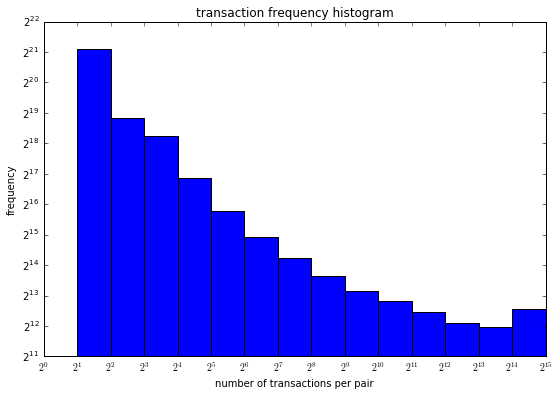

In [5]:
# Time data is not present. Thus, we'll be inferring probability of interaction
# as a stationary distribution over time, informed by the number of iteractions in the past.
series = dftrain['transaction']
title = 'transaction frequency histogram'
xlb = 'number of transactions per pair'
ylb = 'frequency'

print(series.describe())

bins = range(maxlgbin(series))
plt.figure(figsize=(9,6))
plt.axes().set_aspect(9/6)
plt.xticks(bins, [r'$2^{{{}}}$'.format(i) for i in bins])
plt.hist(series, bins=bins)
plt.gca().set_yscale('log', basey=2)
plt.title(title)
plt.xlabel(xlb)
plt.ylabel(ylb)
plt.show()

In [6]:
n_sender = dftrain['sender'].unique().size
n_receiver = dftrain['receiver'].unique().size
n_transactions = dftrain['transaction'].sum()
n_nonmissing = dftrain['transaction'].count()
sparsity = 1 - n_nonmissing*1.0/n_sender/n_receiver
for i in ['n_sender', 'n_receiver', 'n_transactions', 'n_nonmissing', 'sparsity']: print(i, eval(i))

n_sender 443652
n_receiver 439602
n_transactions 15821903
n_nonmissing 3348026
sparsity 0.999982833304


count    444075.000000
mean         35.628898
std        2067.872587
min           0.000000
25%           4.000000
50%           5.000000
75%           8.000000
max      742100.000000
dtype: float64
count    4.440750e+05
mean     3.562890e+01
std      3.404519e+03
min      0.000000e+00
25%      3.000000e+00
50%      4.000000e+00
75%      5.000000e+00
max      1.696391e+06
dtype: float64


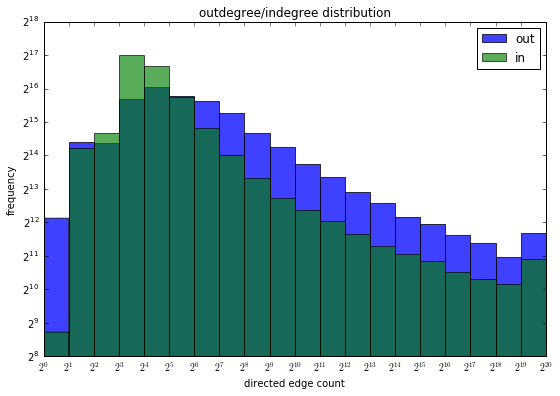

In [7]:
# Direction of edges is sender -> receiver
send_distribution = pd.Series(np.squeeze(np.asarray(train_csr.sum(0))))
recv_distribution = pd.Series(np.squeeze(np.asarray(train_csc.sum(1))))
title = 'outdegree/indegree distribution'
xlb = 'directed edge count'
ylb = 'frequency'

print(send_distribution.describe())
print(recv_distribution.describe())

# http://stackoverflow.com/questions/7694298/how-to-make-a-log-log-histogram-in-python
bins = range(max(maxlgbin(x) for x in (send_distribution, recv_distribution)))
plt.figure(figsize=(9,6))
plt.axes().set_aspect(9/6)
plt.xticks(bins, [r'$2^{{{}}}$'.format(i) for i in bins])
plt.hist(send_distribution, bins=bins, label='out', alpha=0.75)
plt.hist(recv_distribution, bins=bins, label='in', alpha=0.65)
plt.legend()
#plt.legend()#bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.gca().set_yscale('log', basey=2)
plt.title(title)
plt.xlabel(xlb)
plt.ylabel(ylb)
plt.show()

In [8]:
# Get the SCCs (memoized)
import pickle
sccs = None
try:
    with open('train_sccs.p', 'rb') as infile:
        sccs = pickle.load(infile)
except FileNotFoundError:
    print('SCC file missing, recreating SCCs')
    # This takes <1hr on cycles
    sccs = list(nx.strongly_connected_components(G))
    with open('train_sccs.p', 'wb') as outfile:
        pickle.dump(sccs, outfile)

In [9]:
print('# sccs', len(sccs))
series = pd.Series(sorted([len(scc) for scc in sccs]))
title = 'SCC size distribution'
xlb = 'scc sizes'
ylb = 'frequency'
print(series.describe())
for q in [0.9, 0.99, 0.999, 0.9999, 0.99999, 0.999999]:
    print('quantile', q, series.quantile(q))

# sccs 9254
count      9254.000000
mean         47.987357
std        4508.165332
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max      433676.000000
dtype: float64
quantile 0.9 1.0
quantile 0.99 2.0
quantile 0.999 9.747
quantile 0.9999 32866.5748997
quantile 0.99999 393595.05749
quantile 0.999999 429667.905749


In [ ]:
# nearest neighbor
from sklearn.metrics import roc_curve, auc

bincsr = train_csr.sign()
bincsc = train_csc.sign()

pred = [bincsr.getrow(row['sender']) #.dot(bincsc.getcol(row['receiver']))
        for idx, row in dftest.iterrows()]
label = dftest['transaction']
fpr, tpr, thresholds = roc_curve(label, pred)
roc_auc = auc(fpr, tpr)
print('Area under the ROC curve', roc_auc)
matplotlib.rcParams['figure.figsize'] = (10, 10)
plt.plot(fpr, tpr, color='magenta', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

ERROR: Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/n/fs/cyc424/py/lib/python3.3/site-packages/IPython/core/interactiveshell.py", line 2885, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-35-86fc6bce527d>", line 10, in <module>
    fpr, tpr, thresholds = roc_curve(label, pred)
  File "/n/fs/cyc424/py/lib/python3.3/site-packages/sklearn/metrics/ranking.py", line 501, in roc_curve
    y_true, y_score, pos_label=pos_label, sample_weight=sample_weight)
  File "/n/fs/cyc424/py/lib/python3.3/site-packages/sklearn/metrics/ranking.py", line 316, in _binary_clf_curve
    desc_score_indices = np.argsort(y_score, kind="mergesort")[::-1]
  File "/n/fs/cyc424/py/lib/python3.3/site-packages/numpy/core/fromnumeric.py", line 908, in argsort
    return argsort(axis, kind, order)
  File "/n/fs/cyc424/py/lib/python3.3/site-packages/scipy/sparse/compressed.py", line 311, in __gt__
    "Comparing a sparse matrix with a scalar "
  File "/n/fs/cyc424/py/lib/python3.3/site-pa

In [2]:
import os
os.environ['OMP_NUM_THREADS'] = str(nproc)
old_flags = os.environ.get('THEANO_FLAGS', '')
if 'openmp' not in old_flags:
    os.environ['THEANO_FLAGS'] = old_flags + ',openmp=true'

import theano, theano.sparse
print('openmp', theano.config.openmp, 'nthreads', nproc)

import time
def timeddot(x, desc):
    t = time.time()
    y = f(x)
    print(desc, '{}K rows time'.format(x.shape[0] // 1000), time.time() - t)
    return y

x = theano.sparse.csr_matrix(name='x', dtype='float64')
y = theano.sparse.true_dot(x, x.T)
f = theano.function([x], y)
dotprod = timeddot(train_csr[:10000], 'regular')
binprod = timeddot(train_csr[:10000].sign(), 'binary')
logprod = timeddot(train_csr[:10000].log1p(), 'log')


openmp True nthreads 38
regular 10K rows time 0.5797369480133057
binary 10K rows time 0.469343900680542
log 10K rows time 0.4607558250427246


In [3]:
def computstr(x): return eval(i + 'prod' + '.data.mean()')
vals = ['dot', 'bin', 'log']
for i in vals:
    print(i, 'mean', computstr(i))

dot mean 55430.9050005
bin mean 2.19836241129
log mean 7.25920817855


In [22]:
binprod.data.min(), (binprod.data.min() == binprod.data).sum() / len(binprod.data), binprod.data.mean(), binprod.data.std(), binprod.nnz / len(binprod.data)

(1.0, 0.81380906769531913, 2.1983624112867708, 73.687615896000651, 1.0)

In [24]:
def dropval(v, x): return x if x > v else 0
import functools
vfunc = np.vectorize(functools.partial(dropval, binprod.data.min()))

0.0

In [ ]:
#def compute_sim(i, j):
#    return i.dot(j.transpose())
#sim = Parallel(n_jobs=nproc, backend='threading')(
#    delayed(compute_sim)(sample.getrow(i), sample.getrow(j)) for i in range(sample_size) for j in range(i))
decay = 0.9
simil = scipy.sparse.identity(dim)
i1 = decay * train_csr.dot(simil).dot(train_csr.transpose())

In [5]:
import time

In [3]:
# dot perf
import pickle
def run(n):
    if n <= 0: n = 1
    s = train_csr[1:n]
    t = time.time()
    s.dot(train_csr.transpose())
    return time.time() - t
with open('/tmp/csrmat.p', 'wb') as csrmat:
    pickle.dump(train_csr, csrmat)
def partdot(a, b):
    with open('/tmp/csrmat.p', 'rb') as csrmat:
        csr = pickle.load(csrmat)
    res = csr[a:a + b].dot(csr.transpose())

def run2(n, p):
    if n <= 0: n = 1
    t = time.time()
    block_size =  max(n // max(p, 1), 1)
    # originally from SO, but heavily modified and something natural anyway.
    products = Parallel(n_jobs=nproc)(
        delayed(partdot)(i, block_size)
        for i in range(0, n, block_size))
    product = np.vstack(products)
    return time.time() - t
# run3 with theano
r = [5000, 10000, 20000, 30000]
plt.plot(r,[run(n) for n in r])
plt.plot(r,[run2(n, nproc // 2) for n in r])
plt.plot(r,[run2(n, nproc) for n in r])
plt.show()
pass

444075

In [7]:
# (Takes and Kosters 2013) http://www.mdpi.com/1999-4893/6/1/100/htm
# Sample a distribution (only need about 0.1) for these metrics for each vertex
# vertex eccentricity, vertex connectivity, closeness centrality
# betweeness centrality

# (TODO this should come in from B)

Various attempted methods

In [ ]:
#1. linkpred -> figure out what this actually does
# Overall similarity-based algorithm: for undirected (Nowell Kleinberg 2007) - only works for undirected
# AA approach.
#2. graphsim -> can't use similarity(a, b) to predict interaction, but can use similarities to
# predict interaction x -> b) given interaction (x -> a) exists + outward. simrank (https://en.wikipedia.org/wiki/SimRank)
# (https://pypi.python.org/pypi/graphsim) need to find a paper for simrank to cite
# 3. Clustering -> do a coarser clustering by deleting "tenuous" edges, smarter prediction on the cluster.
# (Liben-Nowell and Kleninberg 2007)
# 4. low-rank approximation (paper above works, any other papers for)
# setup CV to evaluate all of these.
# look into NetworkX prediction

In [9]:
# Create a simple CV scheme (relying on our time-stationarity assumption)
# for evaluation.

# The predictor to cross-validate, f, should accept a CSR matrix with historical interaction
# counts and output a 
# TODO: can't do CV easily - don't have temporal info

Area under the ROC curve 0.641620888889


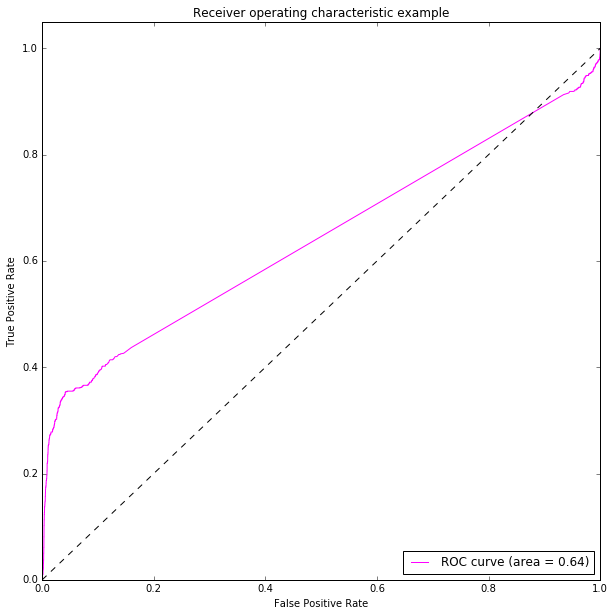

In [10]:
from sklearn.decomposition import TruncatedSVD
from scipy.sparse.linalg import svds
from sklearn.metrics import roc_curve, auc
train_csr = csr_matrix((dftrain['transaction'],(dftrain['sender'],dftrain['receiver'])),
                       shape=(dim,dim),
                       dtype=float)
u, s, vt = svds(train_csr, k=10, tol=1e-10, which = 'LM')
pred = [np.sum(u[row['sender'],:] * s * vt[:,row['receiver']]) 
        for index,row in dftest.iterrows()]
label = dftest['transaction']
fpr, tpr, thresholds = roc_curve(label, pred)
roc_auc = auc(fpr, tpr)
print('Area under the ROC curve', roc_auc)
matplotlib.rcParams['figure.figsize'] = (10, 10)
plt.plot(fpr, tpr, color='magenta', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()